# Cosmic Rays Classification

## Section 1: Introduction

Primary cosmic rays are ultra-high energy particles that originate in space and consistently hit the Earth. They are known to have ultra-high energy as they have energies above $10^7 \, \text{GeV}$ [3]. Identifying the type of particle of a primary cosmic ray is a difficult task, but it is important with regards to understanding the origins of these cosmic rays as well as how they propagate through space. In this project, I will create a machine learning algorithm that can classify the type of particle in an ultra-high energy cosmic ray event. I will do this by analyzing various features of the cosmic ray.

There has been some research already done on this topic. For example, [this](https://www.mdpi.com/1099-4300/22/9/998) article, called "Composition Classification of Ultra-High Energy Cosmic Rays," highlights how the involved researchers of the project classified the particle of various primary cosmic rays using machine learning. The data involved in this project was generated by the Monte Carlo CORSIKA code, which is a simulator for particle interactions [1]. This project brings attention to how classifying the composition of cosmic rays can further our understanding of these events.

For this project, I used the dataset generated by the CORSIKA code, which can be accessed in [this](https://github.com/aguillenATC/Entropy-CompositionClassificationUHECR/tree/master) GitHub repository. It is the same data that was used in the project for the above article. This dataset includes data for five different particles that a cosmic ray can be made out of: helium, iron, nitrogen, photons, and protons. For each particle, there were about 12000 events simulated, so in total, there are approximately 60000 events/records [2]. 

There are five discriminating variables that were measured for each cosmic ray using the CORSIKA code, and they are listed out below. These variable names and descriptions can also be found in the README of the GitHub repository I linked above. 
1. NALLParticlesTotal: number of particles generated at ground level
    - This feature indicates the total number of particles that have reached ground level as a result of the primary cosmic ray interacting with the Earth's atmosphere. If there are more total particles detected, then there is a higher chance of the primary particle being heavier. 
2. MUTotal: number of muons
    - Muons can be produced when cosmic rays interact with the Earth's atmosphere. A higher muon production typically signifies that the cosmic ray has a heavier primary particle. 
3. ELTotal: number of EM particles
    - This feature indicates the total number of electromagnetic particles that are produced in the interaction between the cosmic ray and the Earth's atmosphere. This number is also influenced by the type of primary particle, as well as its energy. 
4. Zenith: Zenith angle of the particle in degrees
    - The zenith angle indicates which direction the incoming particle was detected at relative to the vertical. Heavier particles tend to interact with the Earth's atmosphere earlier than lighter ones, which results in a particle shower that is more spread out and more isotropic. Thus, heavier particles will travel more through the atmosphere before reaching the ground and will have a larger zenith angle. 
5. Energy: Particle energy in GeV
    - The primary particle energy determines the particle's ability to penetrate the Earth's atmosphere, and thus, the amount of secondary particles that are created. Particles with higher energies will have a larger amount of secondary particles. 

As these properties vary for photons, protons, helium, nitrogen, and iron, the simulated data can help us create a machine learning algorithm that can classify what a detected cosmic ray is made out of. 

In order to achieve the goal of classifying cosmic rays, I'll be using a feed-forward neural network to train the data. In the training loop, I used batches in order to have the losses converge with less epochs. Also, to display how well the neural network did, I included a 5x5 confusion matrix where the predicted and true axes are made of the five possible primary particles. To finish up this project, I went through the hyperparameters, such as batch size and learning rate, to see if they can be optimized. 

## Section 2: Data
In this section, I pull my data in from a raw text file from GitHub and make plots of the inputs. The data from GitHub has separated and shuffled the 60000 events into x_train, y_train, x_test, and y_test datasets already. So, for this section, I'm working with the data in the file x_train. 

In [1]:
# Imports for the project
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Get the data from GitHub and read it into the code 
url = 'https://raw.githubusercontent.com/aguillenATC/Entropy-CompositionClassificationUHECR/master/data/XTrn.txt'
x_train_df = pd.read_csv(url, delim_whitespace=True, header=None)


I added headers to the data as the raw text file from GitHub does not include column names. This step introduces what each column corresponds to, as well as displays the first few rows from the x_train dataset. 

In [3]:
headers = ['NALLParticlesTotal', 'MUTotal', 'ELTotal', 'Zenith', 'Energy']
x_train_df.columns = headers
print(x_train_df.head())

   NALLParticlesTotal   MUTotal   ELTotal    Zenith    Energy
0           -0.609229 -0.691944 -0.608663  0.374777 -0.698071
1           -0.389923 -0.343129 -0.389762 -0.762234 -0.465485
2            0.729394  1.481351  0.727433 -2.994604  0.738922
3           -0.507738 -0.700784 -0.507020  1.049799 -0.645296
4           -0.432007 -0.410189 -0.431769  1.105614 -0.524701


Here, I made a list of what features are included in the dataset. I also made the values in the dataset into a 2D array. Each array inside the 2D array contains one row from the dataset. 

In [4]:
# List of features, or "branches"
branches=("NALLParticlesTotal","MUTotal", "ELTotal", "Zenith", "Energy")

# Get the data values
x_train=[[float(i) for i in j] for j in x_train_df.iloc[0:].values]
print(x_train[0])

[-0.60922939, -0.69194438, -0.60866338, 0.37477712, -0.69807074]


In this next cell, I mapped the feature names to the feature data. As the data from the GitHub repository has already been scaled to have mean=0 and variance=1, I did not include a section of code to scale the data again. 

In [5]:
X_train={}
for b in branches:
    X_train[b]=[event[branches.index(b)] for event in x_train]

Next, I plotted the data for each feature as a histogram to get an idea of how each feature looks like. 

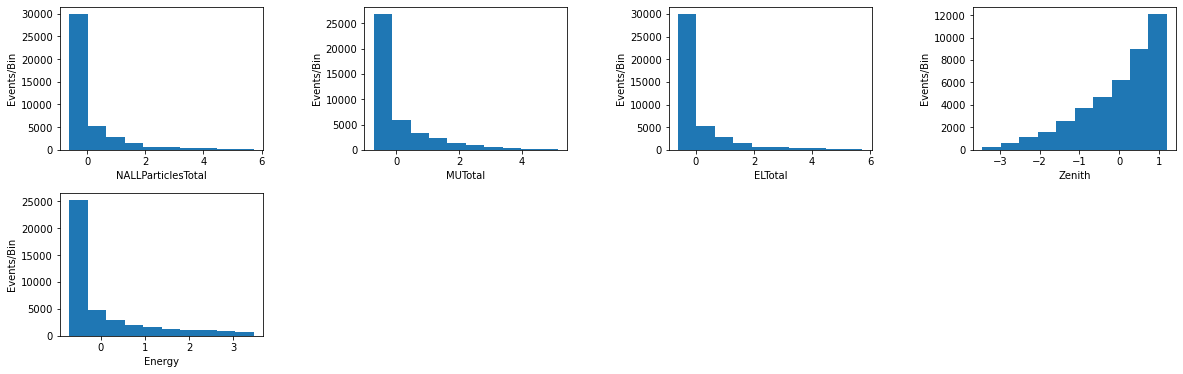

In [6]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
for b in range(len(branches)):
    ax=fig.add_subplot(9,4,1+b if b<8 else 2+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    ax.hist(X_train[branches[b]])
    ax.set_xlabel(branches[b])
    ax.set_ylabel("Events/Bin")

In the next cell, I got the data for x_test, y_train, and y_test and turned them into CSV files. All of these data sets are from the same GitHub repository as I linked above. 

For x_test, I converted the data into a 2D array in order to be able to work with it easier, just as I did for x_train. 

Furthermore, the first few rows of data for y_train are printed out. As we can see, the data is made out of numbers from 0 to 4 with each representing a different primary particle. The number to particle correspondence is written below:
- 0 $\rightarrow$ photon
- 1 $\rightarrow$ proton
- 2 $\rightarrow$ helium
- 3 $\rightarrow$ nitrogen
- 4 $\rightarrow$ iron

Just as a note, x_train and y_train both have 41992 events, while x_test and y_test both have 17996 events. 

In [7]:
# Get x_test and convert this data into a 2D array
url_x_test = 'https://raw.githubusercontent.com/aguillenATC/Entropy-CompositionClassificationUHECR/master/data/XTest.txt'
x_test_df = pd.read_csv(url_x_test, delim_whitespace=True, header=None)
x_test = [[float(i) for i in j] for j in x_test_df.iloc[0:].values]

# Get y_train
url_y_train = 'https://raw.githubusercontent.com/aguillenATC/Entropy-CompositionClassificationUHECR/master/data/YTrn.txt'
y_train_df = pd.read_csv(url_y_train, delim_whitespace=True, header=None)
print(y_train_df)

# Get y_test
url_y_test = 'https://raw.githubusercontent.com/aguillenATC/Entropy-CompositionClassificationUHECR/master/data/YTest.txt'
y_test_df = pd.read_csv(url_y_test, delim_whitespace=True, header=None)

         0
0      4.0
1      1.0
2      2.0
3      0.0
4      1.0
...    ...
41987  4.0
41988  4.0
41989  3.0
41990  3.0
41991  1.0

[41992 rows x 1 columns]


As we want to work with tensors, I converted each of the four arrays into tensors below. Also, for the y_train and y_test datasets, we need to work with 1D tensors, so I converted the respective tensors into 1D tensors. 

In [8]:
# Converting x_train and x_test into tensors 
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Making y_train and y_test into 1D tensors 
y_train_tensor = torch.from_numpy(y_train_df.values).float().flatten()
y_test_tensor = torch.from_numpy(y_test_df.values).float().flatten()

## Section 3: Network
In this section, I construct the neural network that I will use for training and testing my data. As the intention of this project is to predict one of five cosmic ray primary labels, this is a multi-class classification problem. To achieve this, I decided to use a Multilayer Perceptron (MLP), which is a feed-forward neural network. 

My neural network, called cosmic_net, has an input layer with five features, two hidden layers with 32 and 16 nodes, and one output layer with five nodes. I decided to have five features in the input layer as there are five discriminating variables included in my data. I have only two hidden layers as the data is not overly complicated, and more hidden layers may risk overfitting the data. Lastly, I have five nodes in my output layer as there are five classes of data. 

For this neural network, I used the ReLU activation function as it can speed up the training process and help with the gradients. I also involved dropout to improve the generalization of my data and to help prevent overfitting. 

In [9]:
# Building the neural net
torch.manual_seed(123)
cosmic_net = torch.nn.Sequential(
    torch.nn.Linear(5, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.01),
    torch.nn.Linear(16, 5),
)

In [10]:
# Save the network
torch.save(cosmic_net.state_dict(), 'cosmic_net.pth')

## Section 4: Parameters

For this neural network, I'm using a Cross Entropy Loss as this is a multi-class classification problem. 

In [11]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

I will be using a learning rate of 0.001 to train my neural network in order to have more training stability. A learning rate higher than this may not provide the necessary loss stability. 

Also, I'm using 100 batches to train my network. As the training data has 41992 events, each of the batches will have around 420 records. I found this batch size to work the best in terms of overfitting and underfitting. It also pairs well with the learning rate of 0.001 to achieve a stable loss curve. 

In [12]:
# Learning rate
learning_rate = 0.001

# Batch size where len(x_train_df) is 41992
batch_size = int(len(x_train_df)/100)

# As the batch size gets bigger, learning rate should go up 

I will be using the Adam optimizer for this neural network. This optimizer is known to converge quicker than others and also utilizes an adaptive learning rate, so it works best for the data I'm trying to train. 

In [13]:
# Optimizer
optimizer = torch.optim.Adam(cosmic_net.parameters(), lr=learning_rate)

I am using 300 epochs to train the data. 

In [14]:
# Number of epochs 
num_epochs = 300

## Section 5: Execution
In this section, I run the neural network on the training and testing data and get loss curves. 

Below, I create xy_train, which is a tensor dataset made out of the x_train and y_train datasets. I then create a data loader, which shuffles the xy_train data and allows it to be broken into mini batches of a size given above. 

In [15]:
xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor.long())
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

In the following cell, I run my training and testing data through my neural network using batches and plot both loss curves against the training epoch. I also add the predicted testing values to a tensor called y_pred_values to use in the creation of the confusion matrix. 

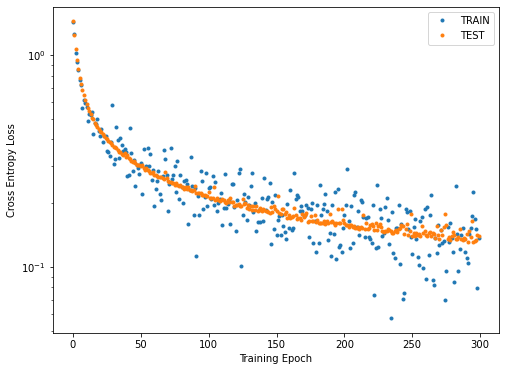

In [16]:
# Reload the seed and load in our initial state
torch.manual_seed(123) 
cosmic_net.load_state_dict(torch.load('cosmic_net.pth')) 

# Create empty lists to store the training and testing losses
losses_train, losses_test = [], []

# Create empty tensor to store the predicted y values 
empty_tensor = torch.empty((0, 5))

# Train the network
cosmic_net.train()
for epoch in range(num_epochs):

    # Training data set
    for x_batch, y_batch in loader:
        y_pred_training = cosmic_net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred_training, y_batch)
        loss.backward()
        optimizer.step()
    losses_train.append(loss.data)
        
    # Testing data set 
    cosmic_net.eval() 
    y_pred_testing = cosmic_net(x_test_tensor)
    losses_test.append(loss_fn(y_pred_testing, y_test_tensor.long()).data)
    
    # Append the predicted value of y to y_pred_values 
    y_pred_values = torch.cat((empty_tensor, y_pred_testing), dim=0)

plt.figure(figsize=(8, 6))
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

As we can see in the plot, the testing loss curve begins to plateau around 300 epochs, and it doesn't seem like the loss will get much lower. 

There is a small sign of overfitting in the testing loss curve, though. As the testing loss curve begins smoothly, it slowly starts to vary more and more as the epochs go on. 

If I had run the training and testing for longer, I don't believe the results would have improved much more. This is due to the fact that both loss curves had already started plateauing after only 300 epochs. 

## Section 6: Results
In this section, I evaluate the performance of the model. As this was a multi-class classification, I created a confusion matrix to display how well the network did. 

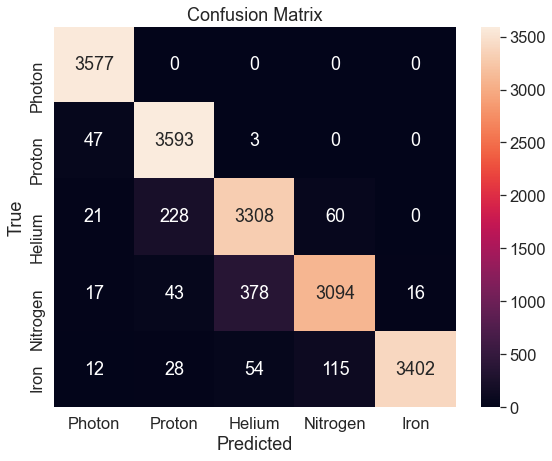

In [23]:
# Get predicted data from each row of the tensors
_, y_predicted = torch.max(y_pred_values, dim=1)

# Convert the tensors to numpy arrays (so it's easier to work with)
y_predicted = y_predicted.numpy()
y_actual = y_test_tensor.numpy()

# Create the confusion matrix
cm = confusion_matrix(y_actual, y_predicted)

# Create figure and set font size for all labels 
plt.figure(figsize=(9, 7))
sns.set(font_scale=1.5)

# Plot the confusion matrix and add labels 
sns.heatmap(cm, annot = True, fmt = "d", 
            xticklabels = ['Photon', 'Proton', 'Helium', 'Nitrogen', 'Iron'], 
            yticklabels = ['Photon', 'Proton', 'Helium', 'Nitrogen', 'Iron'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

As we can see in the confusion matrix, the main diagonal has the majority of the events in the testing dataset. We can go through each primary particle and see how the neural network did:
- Photons: 3577 out of 3577 photons were correctly classified $\rightarrow$ 100% accuracy. 
- Protons: 3593 out of 3643 protons were correctly classified $\rightarrow$ 98.6% accuracy 
- Helium: 3308 out of 3617 helium particles were correcly classified $\rightarrow$ 91.4% accuracy
- Nitrogen: 3094 out of 3548 nitrogen particles were correctly classified $\rightarrow$ 87.2% accuracy
- Iron: 3402 out of 3611 iron particles were correctly classified $\rightarrow$ 94.2% accuracy

This model is quite accurate with photons and protons as both have a high classification accuracy. 

Helium particles were often confused with protons and sometimes with nitrogen particles, and nitrogen particles were most often confused with helium particles. As there was a confusion for both nitrogen and helium, we can conclude that there is some overlap in the discriminating variables for these two particles. This confusion may have been produced for a couple reasons:
- Helium and nitrogen have similar mass-to-charge ratios. 
- Compared with iron, helium and nitrogen are both relatively light particles. This may have led to the network confusing their discriminating variables with each other. 

Iron particles were well classified, but the model did confuse them with nitrogen and helium occasionally. 

Overall, the network performed well in classifying the particle in primary cosmic rays, given the discriminating variables used to predict the output. 

## Section 7: Optimization
In this section, I scan over different values of a couple of the hyperparameters in order to determine the "best" set of hyperparameters. In particular, I am scanning over values of the learning rate and of the batch size. 

### Learning Rate Optimization

Below, I scan over multiple values of the learning rate and display the loss curve for the training data. The values I scanned over are: 0.0001, 0.001, 0.05, 0.1, and 0.25. I chose these values as they represent a wide range of values, from a small learning rate to one on the larger side. 

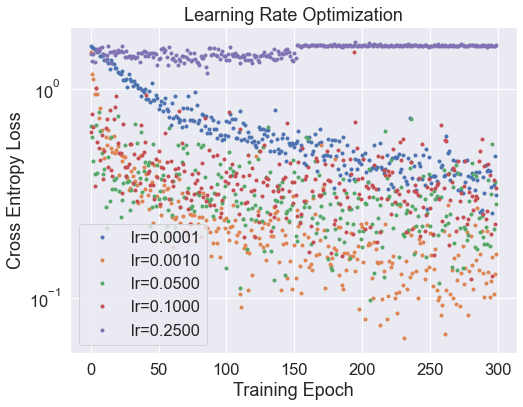

In [18]:
# Learning rate
plt.figure(figsize=(8, 6))
torch.manual_seed(123)
cosmic_net.train()
for learning_rate in (0.0001, 0.001, 0.05, 0.1, 0.25):
    optimizer = torch.optim.Adam(cosmic_net.parameters(), lr=learning_rate)
    cosmic_net.load_state_dict(torch.load('cosmic_net.pth'))
    losses_lr = []
    for epoch in range(num_epochs):
        for x_batch, y_batch in loader:
            y_pred_training = cosmic_net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred_training, y_batch)
            loss.backward()
            optimizer.step()
        losses_lr.append(loss.data)
    plt.plot(losses_lr, '.', label=f'lr={learning_rate:.4f}')
plt.legend()
plt.title('Learning Rate Optimization')
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

As we can see from the plot above, the loss curves corresponding to learning rates of 0.1, 0.05, and 0.001 all were quite noisy. The loss curve corresponding to a learning rate of 0.25 had very low noise, but the loss it converges to is not as low as desired. The loss curve corresponding to a learning rate of 0.0001 also had low noise, but the loss it reaches after 300 epochs is still not as low as desired. Thus, we can conclude that using a learning rate of 0.001 is "best" as it reaches the lowest loss at the end of 300 epochs as compared to the other four loss curves. 

### Batch Size Optimization

Next, I scanned over multiple values of the batch size and plot the loss curve for each. The batch sizes I scanned over are: 42, 420, and 4200. Note that all of these are batch sizes used for the training dataset with about 42000 records. Just like with the learning rate optimization, I chose some batch sizes that are small and some that are a bit larger in order to see the differences between the three batch sizes. 

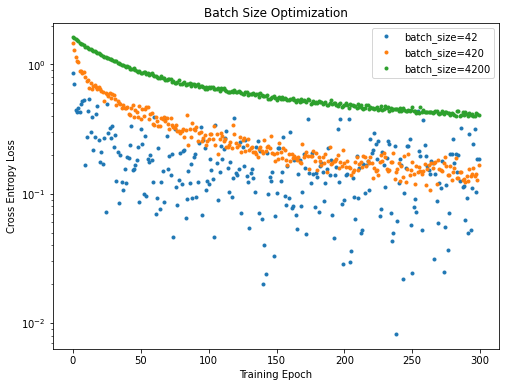

In [16]:
# Batch size 
plt.figure(figsize=(8, 6))
torch.manual_seed(123)
cosmic_net.train()
# learning_rate = 0.001
for batch_size in (42, 420, 4200):
    loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)
    cosmic_net.load_state_dict(torch.load('cosmic_net.pth'))
    losses_batches = []
    for epoch in range(num_epochs):
        for x_batch, y_batch in loader:
            y_pred_training = cosmic_net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred_training, y_batch)
            loss.backward()
            optimizer.step()
        losses_batches.append(loss.data)
    plt.plot(losses_batches, '.', label=f'batch size={batch_size}')
plt.legend()
plt.title('Batch Size Optimization')
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

In the plot above, we can see that using a batch size of 4200 had the least noise in training the data, but the loss curve converged to around 0.4. A batch size of 420 had a loss curve that converged to a little bit less than 0.2 and did have a little bit of noise. A batch size of 42 had a loss curve with a high amount of noise, and doesn't really seem to converge on any one value. As such, it seems that using a batch size of 420 is the most efficient in training the data and is thus a good choice to use in training the data. 

### Optimization Conclusion

Overall, we've found that the "best" set of hyperparameters consist of a learning rate of 0.001 and a batch size of 420.

## References
[1]  ["Composition Classification of Ultra-High Energy Cosmic Rays"](https://www.mdpi.com/1099-4300/22/9/998)

[2]  [GitHub repository](https://github.com/aguillenATC/Entropy-CompositionClassificationUHECR) for the above article

[3]  [Science Direct - Primary Cosmic Rays](https://www.sciencedirect.com/topics/chemistry/primary-cosmic-ray#:~:text=of%20other%20nuclides.-,Primary%20cosmic%20rays%20are%20high%2Denergy%20particles%20from%20outer%20space,%2C%20electrons%2C%20and%20other%20particles.)